# MCMC: Metropolis-Hastings algorithm and diagnostics

Florent Leclercq,<br/>
Institute of Cosmology and Gravitation, University of Portsmouth,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
from scipy.stats import norm, binom, beta
from matplotlib import pyplot as plt
from cycler import cycler
%matplotlib inline

## Generate data

In [2]:
groundtruth = 0.38
Ntrials = 100
Nsuccesses = binom(Ntrials, groundtruth).rvs()
Nsuccesses

38

## Analytic solution

In [3]:
def target_pdf(theta,Ntrials,Nsuccesses,lh,prior):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lh(Ntrials,theta).pmf(Nsuccesses)*prior.pdf(theta)

In [4]:
a = 10
b = 10
lh = binom
prior = beta(a,b)
posterior = beta(a+Nsuccesses, b+Ntrials-Nsuccesses)

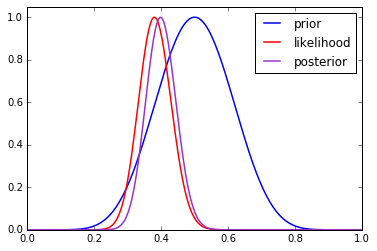

In [5]:
thetas = np.linspace(0, 1, 200)
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.plot(thetas, prior.pdf(thetas)/prior.pdf(thetas).max(),
         color='blue', linewidth=1.5, label="prior")
plt.plot(thetas, lh(Ntrials,thetas).pmf(Nsuccesses)/lh(Ntrials,thetas).pmf(Nsuccesses).max(),
         color='red', linewidth=1.5, label="likelihood")
plt.plot(thetas, posterior.pdf(thetas)/posterior.pdf(thetas).max(),
         color='darkorchid', linewidth=1.5, label="posterior")
plt.xlim([0,1]);
plt.legend(loc='best')
plt.show()

## Metropolis-Hastings sampler

In [6]:
def proposal_pdf(sigma):
    return norm(0,sigma)

In [7]:
def MH_sampler(Ntries,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma):
    Naccepted=0
    samples=np.zeros(Ntries+1)
    samples[0]=theta_start
    theta=theta_start
    for i in xrange(Ntries):
        theta_p = theta + proposal_pdf(proposal_sigma).rvs()
        a = min(1, target_pdf(theta_p,Ntrials,Nsuccesses,lh,prior)/target_pdf(theta,Ntrials,Nsuccesses,lh,prior))
        u = np.random.uniform()
        if u < a:
            Naccepted+=1
            theta=theta_p
        samples[i+1] = theta
    return Naccepted, samples

In [8]:
Ntries=10000
Nburnin=1000
proposal_sigma=0.1
theta_start=0.6
Naccepted, samples = MH_sampler(Ntries,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma)
fraction_accepted=float(Naccepted)/Ntries

In [9]:
fraction_accepted

0.4661

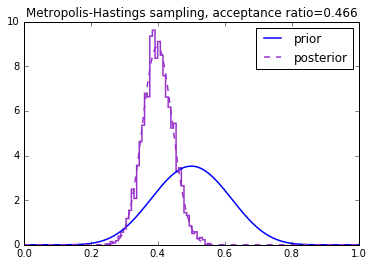

In [10]:
thetas = np.linspace(0, 1, 200)
plt.xlim(0,1)
plt.plot(thetas, prior.pdf(thetas), color='blue', linewidth=1.5, label="prior")
plt.hist(samples[Nburnin:], 40, histtype='step', normed=True, color='darkorchid', linewidth=1.5)
plt.plot(thetas, posterior.pdf(thetas), color='darkorchid', linewidth=1.5, linestyle='--', label="posterior")
plt.title("Metropolis-Hastings sampling, acceptance ratio={:.3f}".format(fraction_accepted))
plt.legend(loc='best')
plt.show()

## Markov Chain diagnostics

### 1- Step size

In [11]:
Ntries=1000
theta_start=0.6

In [12]:
# Suitable step size
proposal_sigma_1=0.1
Naccepted_1, samples_1 = MH_sampler(Ntries,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_1)
fraction_accepted_1=float(Naccepted_1)/Ntries

In [13]:
# Step size too large
proposal_sigma_2=4
Naccepted_2, samples_2 = MH_sampler(Ntries,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_2)
fraction_accepted_2=float(Naccepted_2)/Ntries

In [14]:
# Step size too small
proposal_sigma_3=0.003
Naccepted_3, samples_3 = MH_sampler(Ntries,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_3)
fraction_accepted_3=float(Naccepted_3)/Ntries

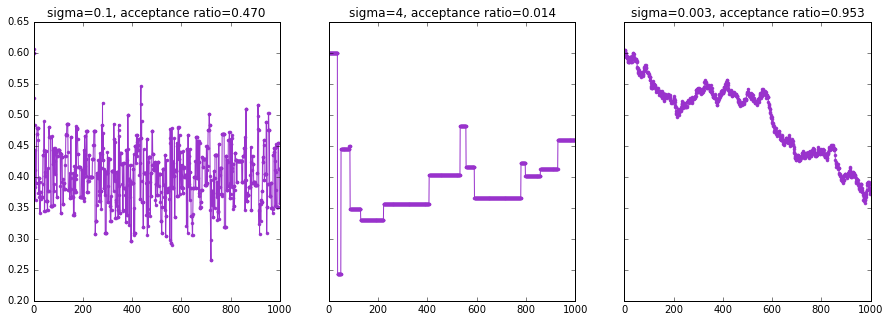

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.set_xlim(0,Ntries)
ax1.plot(np.arange(Ntries+1),samples_1,marker='.',color='darkorchid')
ax1.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_1,fraction_accepted_1))
ax2.set_xlim(0,Ntries)
ax2.plot(np.arange(Ntries+1),samples_2,marker='.',color='darkorchid')
ax2.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_2,fraction_accepted_2))
ax3.set_xlim(0,Ntries)
ax3.plot(np.arange(Ntries+1),samples_3,marker='.',color='darkorchid')
ax3.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_3,fraction_accepted_3))
plt.show()

### 2- Multiple chains, different starting point

In [16]:
Ntries=100
proposal_sigma=0.05

In [17]:
chains = [MH_sampler(Ntries,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma)
          for theta_start in np.arange(0.1,1.0,0.2)]

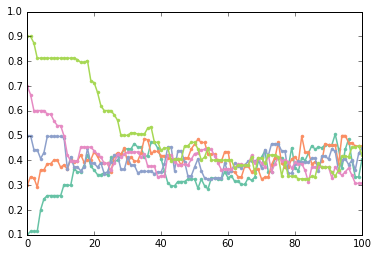

In [18]:
plt.rc('lines', linewidth=2.5)
plt.rc('axes', prop_cycle=(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1., 8)])))
for samples in chains:
    plt.plot(np.arange(Ntries+1),samples[1],marker='.',linewidth=1.5)
plt.show()

### 3- Gelman-Rubin test

Gelman *et al.*, "*Bayesian Data Analysis*" (third edition), p. 284-285

**Parameters**:
* $m$: number of chains
* $n$: length of chains

**Definitions**:
* "between" chains variance:
\begin{equation}
B \equiv \frac{n}{m-1} \sum_{j=1}^m \left( \bar{\psi}_{. j} - \bar{\psi}_{..} \right)^2 \quad \mathrm{where} \quad \bar{\psi}_{. j} = \frac{1}{n} \sum_{i=1}^n \psi_{ij} \quad \mathrm{and} \quad \bar{\psi}_{..} = \frac{1}{m} \sum_{j=1}^m \bar{\psi}_{.j}
\end{equation}
* "within" chains variance:
\begin{equation}
W \equiv \frac{1}{m} \sum_{j=1}^m s_j^2 \quad \mathrm{where} \quad s_j^2 = \frac{1}{n-1} \sum_{i=1}^n \left( \psi_{ij} - \bar{\psi}_{.j} \right)^2
\end{equation}

**Estimators**:
Estimators of the marginal posterior variance of the estimand:
* $\widehat{\mathrm{var}}^- \equiv W$: underestimates the variance
* $\widehat{\mathrm{var}}^+ \equiv \frac{n}{n-1}W + \frac{1}{n} B$: overestimates the variance

**Test**:
* Potential scale reduction factor: $\widehat{R} \equiv \sqrt{\frac{\widehat{\mathrm{var}}^+}{\widehat{\mathrm{var}}^-}}$
* Test: $\widehat{R} \rightarrow 1$ as $n \rightarrow \infty$

In [19]:
Nchains = len(np.arange(0.1,1.0,0.2))
psi_j = np.array([np.mean(chains[j][1]) for j in xrange(Nchains)])
psi = np.mean(psi_j)
B = float(Nchains)/(Ntries-1)*np.sum((psi_j-psi*np.ones(Nchains))**2)
B

0.00063387197529144736

In [20]:
s_j = np.array([1./(Ntries-1)*np.sum((chains[j][1]-psi_j[j])**2) for j in xrange(Nchains)])
W = np.mean(s_j)
W

0.0092415793437909555

In [21]:
var_minus=W
var_plus=float(Ntries)/(Ntries-1)*W+1./Ntries*B
var_minus, var_plus

(0.0092415793437909555, 0.0093412673498447906)

In [22]:
R=np.sqrt(var_plus/var_minus)
R

1.0053789840137546